# **- Pipeline crack detection -**

# **script-V1**

This script imports data and cnverts to the unet input data format correctly.

The unet model understands the input data and is capable of trainning.

Due to the loss of resolution is not posible to obtain evaluable results

# **0. Libraries**

### Installing libraries

In [ ]:
print("Installing segmentation_models....")
!pip install segmentation_models --quiet
print("  -> segmentation_models installed!")

print("Installing patchify....")
!pip install patchify --quiet
print("  -> patchify installed!")

print("\n" + '\033[1m' + "Libraries correctly installed!" + '\033[0m')

Installing segmentation_models....
     |████████████████████████████████| 50 kB 3.5 MB/s 
  -> segmentation_models installed!
Installing patchify....
  -> patchify installed!

Libraries correctly installed!


### Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2

import matplotlib.pyplot as plt
import numpy as np

%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

from sklearn.model_selection import train_test_split
import random

from keras.preprocessing.image import ImageDataGenerator

from patchify import patchify
import tifffile as tiff



Mounted at /content/drive
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# **1. Auxiliar functions**

In [ ]:
class printing_format:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m'

format = printing_format()

class images_storage:
  def __init__(self, good, wrong, roi):
    self.good = good
    self.wrong = wrong
    self.roi = roi

def resize_images( input_images, x, y, z ):

  input_images = np.array( input_images )

  size = len( input_images )
  dim = (x, y)

  output_images = []

  for i in range(0, size):
    img = input_images[i]
    img = cv2.resize(img, dim, interpolation= cv2.INTER_LINEAR)
    if z == 1: img = img[:, :, 0]
    output_images.append( img )

  output_images = np.array( output_images )
  
  return output_images

# **2. DataSet**

### 2.1. Import dataset

In [ ]:
%cd '/content/drive/MyDrive/PBL-SecondSemester/DeepLearning/DataSet'
print()
!ls

/content/drive/.shortcut-targets-by-id/1LFMENSUeZANGJsWPtbb3BcvK4y9YdVWF/PBL-SecondSemester/DeepLearning/DataSet

Onak  Txarrak  unet


In [ ]:
## Importing good ones

print(format.bold + " -- GOOD IMAGES --\n" + format.end)

files = os.listdir( "Onak" )

print("Files in directory:\t" + str(len( files )))

good_img = []

for file in files:
  good_img.append( cv2.imread("Onak/" + file ) )

print("Imported images: \t" + str(len( good_img )))


## Importing wrong ones

print(format.bold + "\n -- WRONG IMAGES --\n" + format.end)

files = os.listdir( "Txarrak" )

print("Files in directory:\t" + str(len( files )))

files = sorted(files)

wrong_img = []
wrong_roi = []

for file in files:
  img = cv2.imread( "Txarrak/" + file )

  if file.endswith("_ROI.bmp"):
    wrong_roi.append( img )
  else:
    wrong_img.append( img )

print("Imported data:")
print("  -> Images: \t\t" + str(len( wrong_img )))
print("  -> ROI:    \t\t" + str(len( wrong_roi )))

save_img = images_storage( good_img, wrong_img, wrong_roi )

print(format.bold + "\n -- IMAGES SIZE --\n" + format.end)
print("  Good images: \t" + str( good_img[0].shape ) )
print("  Wrong images:\t" + str( wrong_img[0].shape ) )
print("  ROI images:  \t" + str( wrong_roi[0].shape ) )

 -- GOOD IMAGES --

Files in directory:	150
Imported images: 	150

 -- WRONG IMAGES --

Files in directory:	290
Imported data:
  -> Images: 		145
  -> ROI:    		145

 -- IMAGES SIZE --

  Good images: 	(942, 944, 3)
  Wrong images:	(943, 923, 3)
  ROI images:  	(943, 923, 3)


### 2.2. Dataset format

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Resized data:
  Good images: 	(150, 64, 64, 3)
  Wrong images:	(145, 64, 64, 3)
  ROI images:  	(145, 64, 64)



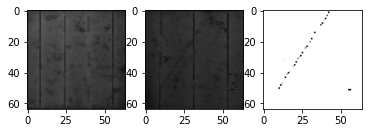

In [ ]:
x_size = 64
y_size = 64

good_img  = np.array( resize_images( save_img.good, x_size, y_size, 0 ), dtype = 'int16' )
wrong_img = np.array( resize_images( save_img.wrong, x_size, y_size, 0 ), dtype = 'int16' )

img = []
for i in range(0, len(save_img.roi)): img.append( cv2.cvtColor(save_img.roi[i], cv2.COLOR_BGR2GRAY) )
roi_img = np.array( resize_images( img, x_size, y_size, 0 ), dtype = ('int16') )

print()
print(format.bold + "Resized data:" + format.end)
print("  Good images: \t" + str( good_img.shape ) )
print("  Wrong images:\t" + str( wrong_img.shape ) )
print("  ROI images:  \t" + str( roi_img.shape ) )
print()

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow( good_img[1])
plt.subplot(132)
plt.imshow( wrong_img[52])
plt.subplot(133)
plt.imshow( roi_img[52], cmap = "gray" )
plt.show()

# **3. Define UNET model**

In [ ]:
images = wrong_img
masks = roi_img

print(format.bold + "Data format:" + format.end)
print("  Images: \t" + str( images.shape ) )
print("  Masks:  \t" + str( masks.shape ) )

Data format:
  Images: 	(145, 64, 64, 3)
  Masks:  	(145, 64, 64)


In [ ]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.1, random_state = 0)

Splited data:
  x_train: 	(130, 64, 64, 3)	 - int16
  y_train: 	(130, 64, 64)		 - int16
  x_test:  	(15, 64, 64, 3)		 - int16
  y_test:  	(15, 64, 64)		 - int16

Max-Min (5):
  x_train: 	12 - 70
  x_test:  	26 - 169
  y_train: 	0 - 255
  y_test:  	0 - 255

Index: 	5


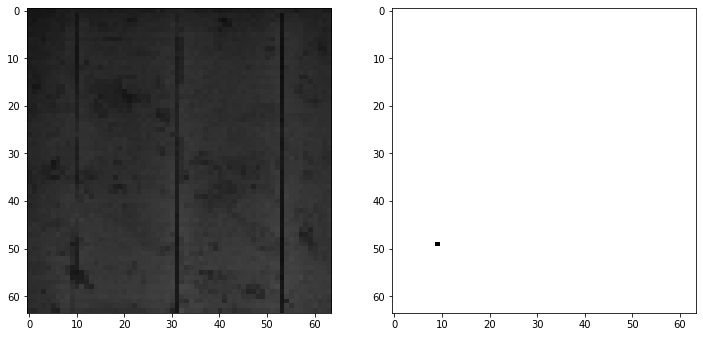

In [ ]:
#Sanity check

print(format.bold + "Splited data:" + format.end)
print("  x_train: \t" + str( X_train.shape ) + "\t - " + str( X_train.dtype ) )
print("  y_train: \t" + str( y_train.shape ) + "\t\t - " + str( y_train.dtype ) )
print("  x_test:  \t" + str( X_test.shape ) + "\t\t - " + str( X_test.dtype ) )
print("  y_test:  \t" + str( y_test.shape ) + "\t\t - " + str( y_test.dtype ) )

index = random.randint(0, len(X_test) - 1)
print("\n" + format.bold + "Max-Min (" + str(index) + "):" + format.end)
print( "  x_train: \t" + str( X_train[index, :, :, 0].min() ) + " - "  + str( X_train[index, :, :, 0].max() ) )
print( "  x_test:  \t" + str( X_test[index, :, :, 0].min() ) + " - "  + str( X_test[index, :, :, 0].max() ) )
print( "  y_train: \t" + str( y_train[index, :, :].min() ) + " - "  + str( y_train[index, :, :].max() ) )
print( "  y_test:  \t" + str( y_test[index, :, :].min() ) + " - "  + str( y_test[index, :, :].max() ) )


print("\n" + format.bold + "Index: \t" + format.end + str(index) )
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow( X_train[index, :, :])
plt.subplot(122)
plt.imshow( y_train[index], cmap = "gray" )
plt.show()

Splited data:
  x_train: 	(130, 64, 64, 3)	 - float64
  y_train: 	(130, 64, 64)		 - float64
  x_test:  	(15, 64, 64, 3)		 - float64
  y_test:  	(15, 64, 64)		 - float64

Max-Min (5):
  x_train: 	0.047058823529411764 - 0.27450980392156865
  y_train: 	0.0 - 1.0

Index: 	5


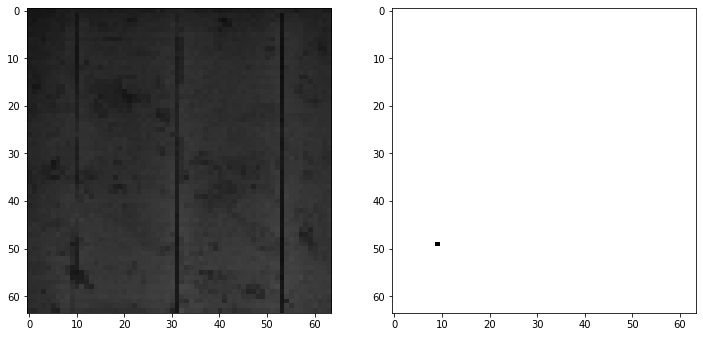

In [ ]:
train_x = X_train / 255
test_x  = X_test / 255
train_y = y_train > 20
test_y = y_test > 20

train_y = train_y.astype('float64')
test_y = test_y.astype('float64')

print(format.bold + "Splited data:" + format.end)
print("  x_train: \t" + str( train_x.shape ) + "\t - " + str( train_x.dtype ) )
print("  y_train: \t" + str( train_y.shape ) + "\t\t - " + str( train_y.dtype ) )
print("  x_test:  \t" + str( test_x.shape ) + "\t\t - " + str( test_x.dtype ) )
print("  y_test:  \t" + str( test_y.shape ) + "\t\t - " + str( test_y.dtype ) )

print("\n" + format.bold + "Max-Min (" + str(index) + "):" + format.end)
print( "  x_train: \t" + str( train_x[index, :, :, 0].min() ) + " - "  + str( train_x[index, :, :, 0].max() ) )
print( "  y_train: \t" + str( train_y[index, :, :].min() ) + " - "  + str( train_y[index, :, :].max() ) )

print("\n" + format.bold + "Index: \t" + format.end + str(index) )
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow( train_x[index, :, :])
plt.subplot(122)
plt.imshow( train_y[index], cmap = "gray" )
plt.show()


In [ ]:
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet')
model.compile('Adam', loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])
# print( model.summary() )

In [ ]:
history = model.fit(x = train_x, y = train_y, validation_data = (test_x, test_y), steps_per_epoch = 50, epochs = 50)

Epoch 1/50
50/50 [==============================] - 52s 794ms/step - loss: 0.4769 - iou_score: 0.7895 - val_loss: 0.1662 - val_iou_score: 0.9301
Epoch 2/50
50/50 [==============================] - 40s 792ms/step - loss: 0.0987 - iou_score: 0.9581 - val_loss: 0.2159 - val_iou_score: 0.8973
Epoch 3/50
50/50 [==============================] - 39s 773ms/step - loss: 0.0555 - iou_score: 0.9798 - val_loss: 0.0729 - val_iou_score: 0.9680
Epoch 4/50
50/50 [==============================] - 39s 781ms/step - loss: 0.0556 - iou_score: 0.9836 - val_loss: 0.0389 - val_iou_score: 0.9859
Epoch 5/50
50/50 [==============================] - 39s 776ms/step - loss: 0.0424 - iou_score: 0.9875 - val_loss: 0.0327 - val_iou_score: 0.9901
Epoch 6/50
50/50 [==============================] - 39s 779ms/step - loss: 0.0407 - iou_score: 0.9887 - val_loss: 0.0298 - val_iou_score: 0.9920
Epoch 7/50
50/50 [==============================] - 38s 761ms/step - loss: 0.0402 - iou_score: 0.9896 - val_loss: 0.0312 - val_iou

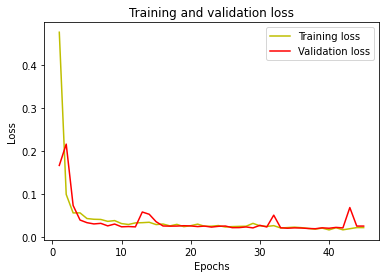

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

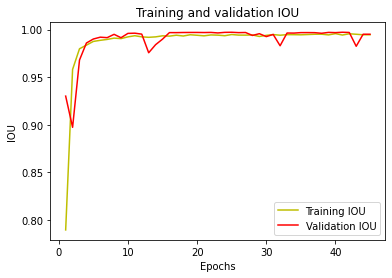

In [ ]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
test = model.predict(test_x)

(15, 64, 64, 1)


TypeError: ignored

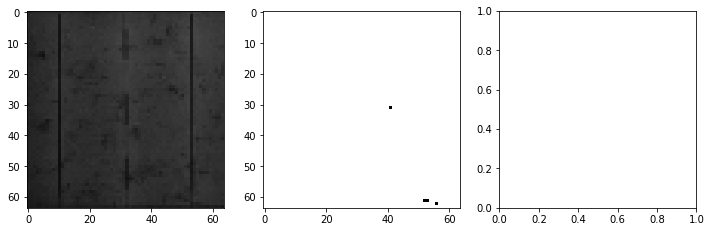

In [ ]:
print(test.shape)

index = 4

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow( test_x[index, :, :])
plt.subplot(132)
plt.imshow( test_y[index], cmap = "gray" )
plt.subplot(133)
plt.imshow( test[index, :, :, 0])
plt.show()



# **4. Output processing**

# **5. Evaluate results**